In [1]:
import ast
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import re
import sys

from collections import Counter, defaultdict
from ggplot import *
from nltk.tokenize import TreebankWordTokenizer
import scipy.sparse
from sklearn import metrics
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.decomposition import PCA, TruncatedSVD, NMF
from sklearn.ensemble import RandomForestRegressor
from sklearn.grid_search import GridSearchCV
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import scale, Normalizer, StandardScaler

/Users/Lillyan/anaconda2/lib/python2.7/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/Users/Lillyan/anaconda2/lib/python2.7/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/Users/Lillyan/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/Users/Lillyan/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored cl

In [2]:
reload(sys)  
sys.setdefaultencoding('utf8')

In [3]:
NUM_RATINGS_TYPES = 26
NUM_TAGS_TYPES = 20
CLUSTER_NUM = 5
DROP_ROWS = ['main_speaker', 'description', 'main_speaker', 'name', 'tags', 'ratings', 'related_talks', 'speaker_occupation', 'title', 'url']

'''
Rating Reference
{1: 'Beautiful',
 2: 'Confusing',
 3: 'Courageous',
 7: 'Funny',
 8: 'Informative',
 9: 'Ingenious',
 10: 'Inspiring',
 11: 'Longwinded',
 21: 'Unconvincing',
 22: 'Fascinating',
 23: 'Jaw-dropping',
 24: 'Persuasive',
 25: 'OK',
 26: 'Obnoxious'}
'''

"\nRating Reference\n{1: 'Beautiful',\n 2: 'Confusing',\n 3: 'Courageous',\n 7: 'Funny',\n 8: 'Informative',\n 9: 'Ingenious',\n 10: 'Inspiring',\n 11: 'Longwinded',\n 21: 'Unconvincing',\n 22: 'Fascinating',\n 23: 'Jaw-dropping',\n 24: 'Persuasive',\n 25: 'OK',\n 26: 'Obnoxious'}\n"

In [4]:
tedData = pd.read_csv('ted_main.csv', converters={"views":int})

In [5]:
def build_ratings_tags_dict(ratings_tags_dict, data):
    for talk_idx in range(len(data)):
        rating_lst = ast.literal_eval(data['ratings'][talk_idx])
        for rating in rating_lst:
            rating_id = rating['id']
            name = rating['name']
            ratings_tags_dict[rating_id] = name
            if len(ratings_tags_dict) == NUM_RATINGS_TYPES:
                break
    return ratings_tags_dict

ratings_tags_dict = build_ratings_tags_dict({}, tedData)

In [6]:
def ratings_conversion(data):
    rows = data.shape[0]
    ratings_mtx = np.zeros((rows, NUM_RATINGS_TYPES))
    for talk_idx in range(len(data)):
        rating_lst = ast.literal_eval(data['ratings'][talk_idx])
        for rating in rating_lst:
            rating_id = rating['id'] - 1 # subtract for 0 index
            count = rating['count']
            ratings_mtx[talk_idx,rating_id] = count
    row_sum = np.sum(ratings_mtx, axis=1)
    ratings_mtx = ratings_mtx / row_sum.reshape(row_sum.size,1)
    # Data Clean
    valid_indices = np.sum(ratings_mtx, axis=0).nonzero()[0]
    ratings_mtx = ratings_mtx[:,valid_indices]
    df = pd.DataFrame(ratings_mtx, columns=list(ratings_tags_dict.values()))
    return df

In [7]:
ratings_mtx = ratings_conversion(tedData)

In [8]:
ratings_mtx

,Beautiful,Confusing,Courageous,Funny,Informative,Ingenious,Inspiring,Longwinded,Unconvincing,Fascinating,Jaw-dropping,Persuasive,OK,Obnoxious
0,0.048727,0.002579,0.034662,0.209323,0.078274,0.064710,0.265573,0.004124,0.003197,0.112744,0.047299,0.114054,0.012509,0.002227
1,0.019755,0.021117,0.047343,0.185286,0.150886,0.019074,0.140668,0.038488,0.087875,0.044959,0.039510,0.091281,0.069142,0.044619
2,0.021246,0.009561,0.015935,0.341360,0.139873,0.064802,0.081445,0.027620,0.036827,0.058782,0.019122,0.081445,0.051700,0.050283
3,0.078058,0.008584,0.203863,0.015826,0.101931,0.028165,0.287017,0.014217,0.009657,0.035408,0.061695,0.123391,0.022800,0.009388
4,0.036768,0.002810,0.012412,0.054254,0.212061,0.124980,0.112920,0.004294,0.002615,0.179781,0.145824,0.099219,0.009680,0.002381
5,0.045976,0.019601,0.046952,0.071763,0.067596,0.025853,0.339346,0.018560,0.024551,0.087914,0.043566,0.157788,0.028718,0.021816
6,0.046182,0.012004,0.079527,0.414138,0.037679,0.053351,0.073024,0.032177,0.037513,0.052684,0.010170,0.051851,0.051350,0.048349
7,0.095703,0.024414,0.033203,0.008789,0.118164,0.190430,0.170898,0.025391,0.025391,0.149414,0.055664,0.036133,0.061523,0.004883
8,0.036746,0.017739,0.142423,0.015205,0.157881,0.053472,0.111759,0.044856,0.071718,0.079321,0.015205,0.193614,0.039027,0.021034
9,0.092110,0.013330,0.057163,0.003122,0.036508,0.013931,0.306953,0.036748,0.100636,0.055122,0.025099,0.185301,0.029422,0.044554


In [9]:
def transformEventData(data):
    categorical = []
    for col, value in data.iteritems():
        if col == 'event':
            categorical.append(col)
    numerical = data.columns.difference(categorical)
    data_cat = data[categorical]
    data_cat = pd.get_dummies(data_cat)
    data_num = data[numerical]
    return pd.concat([data_num, data_cat], axis=1)

In [10]:
trans_tedData = transformEventData(tedData).drop(DROP_ROWS, axis=1)

In [11]:
def build_tag_dict(data):
    tag_dict = defaultdict(int)
    for talk_idx in range(len(data)):
        tag_lst = ast.literal_eval(data['tags'][talk_idx])
        for tag in tag_lst:
            tag_dict[tag] += 1
    tag_count = Counter(tag_dict)
    return [tup[0] for tup in tag_count.most_common(NUM_TAGS_TYPES)]

top_tags = build_tag_dict(tedData)

In [12]:
top_tags

['technology',
 'science',
 'global issues',
 'culture',
 'TEDx',
 'design',
 'business',
 'entertainment',
 'health',
 'innovation',
 'society',
 'art',
 'social change',
 'future',
 'communication',
 'biology',
 'creativity',
 'humanity',
 'collaboration',
 'environment']

In [13]:
def tags_conversion(data):
    rows = data.shape[0]
    tags_mtx = np.zeros((rows, NUM_TAGS_TYPES))
    for talk_idx in range(len(data)):
        tag_lst = ast.literal_eval(data['tags'][talk_idx])
        for tag_ind in range(len(top_tags)):
            top_tag = top_tags[tag_ind]
            if top_tag in tag_lst:
                tags_mtx[talk_idx,tag_ind] = 1
    df = pd.DataFrame(tags_mtx, columns=top_tags)
    return df

In [14]:
tags_data = tags_conversion(tedData)

In [15]:
tags_data

,technology,science,global issues,culture,TEDx,design,business,entertainment,health,innovation,society,art,social change,future,communication,biology,creativity,humanity,collaboration,environment
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
cleaned_tedData = pd.concat([tags_data, trans_tedData,ratings_mtx], axis=1)

In [17]:
cleaned_tedData

,technology,science,global issues,culture,TEDx,design,business,entertainment,health,innovation,...,Informative,Ingenious,Inspiring,Longwinded,Unconvincing,Fascinating,Jaw-dropping,Persuasive,OK,Obnoxious
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.078274,0.064710,0.265573,0.004124,0.003197,0.112744,0.047299,0.114054,0.012509,0.002227
1,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.150886,0.019074,0.140668,0.038488,0.087875,0.044959,0.039510,0.091281,0.069142,0.044619
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.139873,0.064802,0.081445,0.027620,0.036827,0.058782,0.019122,0.081445,0.051700,0.050283
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.101931,0.028165,0.287017,0.014217,0.009657,0.035408,0.061695,0.123391,0.022800,0.009388
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.212061,0.124980,0.112920,0.004294,0.002615,0.179781,0.145824,0.099219,0.009680,0.002381
5,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.067596,0.025853,0.339346,0.018560,0.024551,0.087914,0.043566,0.157788,0.028718,0.021816
6,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.037679,0.053351,0.073024,0.032177,0.037513,0.052684,0.010170,0.051851,0.051350,0.048349
7,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.118164,0.190430,0.170898,0.025391,0.025391,0.149414,0.055664,0.036133,0.061523,0.004883
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.157881,0.053472,0.111759,0.044856,0.071718,0.079321,0.015205,0.193614,0.039027,0.021034
9,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.036508,0.013931,0.306953,0.036748,0.100636,0.055122,0.025099,0.185301,0.029422,0.044554


## KMeans Clustering

In [18]:
kmeans = KMeans(init='k-means++', n_clusters=5, n_init=CLUSTER_NUM)
kmeans.fit(cleaned_tedData)
kmeanlabels=kmeans.labels_

In [19]:
def build_cluster_mapping_and_size(cluster_labels):
    cnt_dict_size = defaultdict(int)
    cnt_dict = defaultdict(list)
    tedId_to_clusterId = {}
    for idx in range(len(cluster_labels)):
        clust_label = cluster_labels[idx]
        tedId_to_clusterId[idx] = clust_label
        cnt_dict_size[clust_label] += 1
        cnt_dict[clust_label].append(idx)
    return cnt_dict, cnt_dict_size, tedId_to_clusterId

In [20]:
clusterId_to_tedId, cnt_dict_size, tedId_to_clusterId = build_cluster_mapping_and_size(kmeanlabels)

In [21]:
cnt_dict_size

defaultdict(int, {0: 706, 1: 712, 2: 739, 3: 6, 4: 387})

In [32]:
n_sne = 7000
rndperm = np.random.permutation(cleaned_tedData.shape[0])
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(cleaned_tedData.loc[rndperm[:n_sne],list(cleaned_tedData.columns.values)].values)

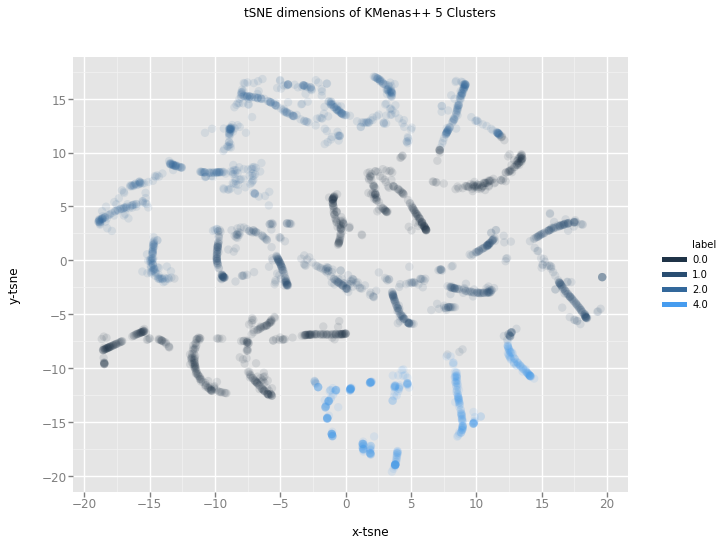

<ggplot: (7545504181)>

In [33]:
df_tsne = cleaned_tedData.loc[rndperm[:n_sne],:].copy()
df_tsne['x-tsne'] = tsne_results[:,0]
df_tsne['y-tsne'] = tsne_results[:,1]
labels = []
for index, row in df_tsne.iterrows():
    labels.append(tedId_to_clusterId[index])
df_tsne['label'] = labels

chart = ggplot(df_tsne, aes(x='x-tsne', y='y-tsne', color='label') ) \
        + geom_point(size=70,alpha=0.1) \
        + ggtitle("tSNE dimensions of KMenas++ 5 Clusters") \
        + scale_color_brewer(type='diverging', palette=3)
chart

In [34]:
features = list(cleaned_tedData.columns.values)
X = cleaned_tedData.loc[:, features].values
x = StandardScaler().fit_transform(X)
y = df_tsne.loc[:,['label']].values
pca = PCA(n_components=2, svd_solver='full')
principalComponents = pca.fit_transform(x)

In [35]:
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [36]:
finalDf = pd.concat([principalDf, df_tsne[['label']]], axis = 1)

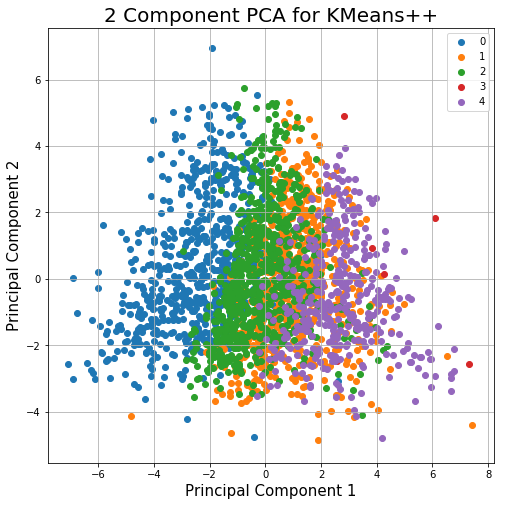

In [37]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA for KMeans++', fontsize = 20)
targets = [0,1,2,3,4]
colors = ['r', 'g', 'b','y','p']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['label'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2'])
ax.legend(targets)
ax.grid()

In [41]:
pickle.dump(clusterId_to_tedId, open( "data/clus50K+clusterId_to_tedId50.pickle", "wb" ), protocol=2)

In [42]:
pickle.dump(tedId_to_clusterId, open( "data/clus50K+tedId_to_clusterId50.pickle", "wb" ), protocol=2)

In [73]:
copy_tedData = tedData
copy_tedData = copy_tedData.drop(['ratings'], axis=1)
copy_tedData = pd.concat([copy_tedData,ratings_mtx], axis=1)

,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,published_date,...,Informative,Ingenious,Inspiring,Longwinded,Unconvincing,Fascinating,Jaw-dropping,Persuasive,OK,Obnoxious
0,4553,Sir Ken Robinson makes an entertaining and pro...,1164,TED2006,1140825600,60,Ken Robinson,Ken Robinson: Do schools kill creativity?,1,1151367060,...,0.078274,0.064710,0.265573,0.004124,0.003197,0.112744,0.047299,0.114054,0.012509,0.002227
1,265,With the same humor and humanity he exuded in ...,977,TED2006,1140825600,43,Al Gore,Al Gore: Averting the climate crisis,1,1151367060,...,0.150886,0.019074,0.140668,0.038488,0.087875,0.044959,0.039510,0.091281,0.069142,0.044619
2,124,New York Times columnist David Pogue takes aim...,1286,TED2006,1140739200,26,David Pogue,David Pogue: Simplicity sells,1,1151367060,...,0.139873,0.064802,0.081445,0.027620,0.036827,0.058782,0.019122,0.081445,0.051700,0.050283
3,200,"In an emotionally charged talk, MacArthur-winn...",1116,TED2006,1140912000,35,Majora Carter,Majora Carter: Greening the ghetto,1,1151367060,...,0.101931,0.028165,0.287017,0.014217,0.009657,0.035408,0.061695,0.123391,0.022800,0.009388
4,593,You've never seen data presented like this. Wi...,1190,TED2006,1140566400,48,Hans Rosling,Hans Rosling: The best stats you've ever seen,1,1151440680,...,0.212061,0.124980,0.112920,0.004294,0.002615,0.179781,0.145824,0.099219,0.009680,0.002381
5,672,"Tony Robbins discusses the ""invisible forces"" ...",1305,TED2006,1138838400,36,Tony Robbins,Tony Robbins: Why we do what we do,1,1151440680,...,0.067596,0.025853,0.339346,0.018560,0.024551,0.087914,0.043566,0.157788,0.028718,0.021816
6,919,When two young Mormon missionaries knock on Ju...,992,TED2006,1140739200,31,Julia Sweeney,Julia Sweeney: Letting go of God,1,1152490260,...,0.037679,0.053351,0.073024,0.032177,0.037513,0.052684,0.010170,0.051851,0.051350,0.048349
7,46,Architect Joshua Prince-Ramus takes the audien...,1198,TED2006,1140652800,19,Joshua Prince-Ramus,Joshua Prince-Ramus: Behind the design of Seat...,1,1152490260,...,0.118164,0.190430,0.170898,0.025391,0.025391,0.149414,0.055664,0.036133,0.061523,0.004883
8,852,Philosopher Dan Dennett calls for religion -- ...,1485,TED2006,1138838400,32,Dan Dennett,Dan Dennett: Let's teach religion -- all relig...,1,1153181460,...,0.157881,0.053472,0.111759,0.044856,0.071718,0.079321,0.015205,0.193614,0.039027,0.021034
9,900,"Pastor Rick Warren, author of ""The Purpose-Dri...",1262,TED2006,1140825600,31,Rick Warren,Rick Warren: A life of purpose,1,1153181460,...,0.036508,0.013931,0.306953,0.036748,0.100636,0.055122,0.025099,0.185301,0.029422,0.044554


In [75]:
copy_tedData.to_csv("ted_talks_ratings.csv")

## Spectral Clustering

### Build SVD Matrix

In [47]:
def build_inverted_index(msgs, text_data_type):
    index = defaultdict(list)
    
    for i in range(0, len(msgs)):
        # Counter to count all occurences of word in tokenized message
        if text_data_type == "description":
            if msgs[i][text_data_type][1] == "":
                text_data = msgs[i][text_data_type][0]
            else:
                text_data = msgs[i][text_data_type][1]
        else:
            text_data = msgs[i][text_data_type]
        stemmed_counts = Counter(tokenizer.tokenize(text_data.lower()))
        
        # Add to dictionary
        for word in stemmed_counts:
            index[word].append((i, stemmed_counts[word]))
            
    return index


def compute_idf(inv_idx, n_docs, min_df=10, max_df_ratio=0.95):
    idf = {}
    
    for word, idx in inv_idx.items():
        word_docs = len(idx)
        
        # Word in too few documents
        if word_docs < min_df:
            continue
        # Word in > 95% docs
        elif float(word_docs)/n_docs > max_df_ratio:
            continue
        else:
            idf[word] = math.log(n_docs/(1+word_docs), 2)
    
    return idf

def compute_doc_norms(index, idf, n_docs):
    norms = np.zeros(n_docs)
    
    for word, idx in index.items():
        for doc_id, tf in idx:
            # Make sure word has not been pruned
            if word in idf:
                norms[doc_id] += (tf*idf[word])** 2
        
    return np.sqrt(norms)

def get_tfidf(inv_idx, idf):
    doc_word_counts = np.zeros([ len(all_talks), len(inv_idx) ])
    list_inv_index = list(inv_idx.items())
    for word_id in range(len(list_inv_index)):
        word, postings = list_inv_index[word_id]
        for d_id, tf in postings:
            doc_word_counts[d_id, word_id] = tf*idf[word]
    return doc_word_counts

def svd(tfidf):
    # modified from http://www.datascienceassn.org/sites/default/files/users/user1/lsa_presentation_final.pdf
    lsa = TruncatedSVD(200, algorithm = 'randomized')
    red_lsa = lsa.fit_transform(tfidf)
    red_lsa = Normalizer(copy=False).fit_transform(red_lsa)
    similarity = np.asarray(np.asmatrix(red_lsa) * np.asmatrix(red_lsa).T)
    return similarity

In [48]:
tokenizer = TreebankWordTokenizer()

### Load SVD Matrix

In [38]:
svd_similarity = np.load("data/svd_similarity.npy")

In [39]:
rows = tedData.shape[0]
spec_ted = np.zeros((rows,rows))

### Create Mapping Dictionaries (due to invalid mappings)

In [40]:
tedId_to_related = {}
title_to_tedId = {}

for idx, row in tedData.iterrows():
    title = str(re.sub(' +',' ', row['title'].decode('ascii', 'ignore')))
    title_to_tedId[title] = idx

In [41]:
for idx, row in tedData.iterrows():
    related_talks = ast.literal_eval(row['related_talks'])
    for rel_talk in related_talks:
        title = str(re.sub(' +',' ', rel_talk['title'].decode('ascii', 'ignore')))
        rel_id = title_to_tedId[title]
        if idx in tedId_to_related:
            tedId_to_related[idx].append(rel_id)
        else:
            tedId_to_related[idx] = [rel_id]

In [42]:
for talkId, rel_talk_lst in tedId_to_related.items():
    for relId in rel_talk_lst:
        sim = svd_similarity[talkId, relId]
        spec_ted[talkId, relId] = max(sim,0)

### Spectral Clustering

In [54]:
sc = SpectralClustering(n_clusters=5, affinity='precomputed', n_init=10)
sc.fit(spec_ted)
sc_labels = sc.labels_

In [55]:
sc_clusterId_to_tedId, sc_cnt_dict_size, sc_tedId_to_clusterId = build_cluster_mapping_and_size(sc_labels)

In [56]:
sc_cnt_dict_size

defaultdict(int, {0: 2246, 1: 8, 2: 52, 3: 56, 4: 188})

In [46]:
n_sne = 7000
rndperm = np.random.permutation(cleaned_tedData.shape[0])
tsne_sc = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results_sc = tsne.fit_transform(spec_ted[rndperm[:n_sne]])

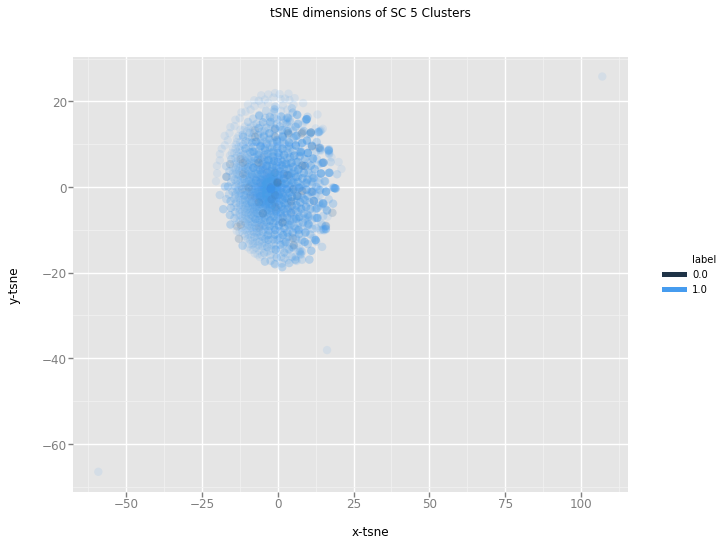

<ggplot: (7559874853)>

In [47]:
sc_df = pd.DataFrame()
sc_df['x-tsne'] = tsne_results_sc[:,0]
sc_df['y-tsne'] = tsne_results_sc[:,1]
sc_labels = []
for index, row in sc_df.iterrows():
    sc_labels.append(sc_tedId_to_clusterId[index])
sc_df['label'] = sc_labels

chart = ggplot(sc_df, aes(x='x-tsne', y='y-tsne', color='label') ) \
        + geom_point(size=70,alpha=0.1) \
        + ggtitle("tSNE dimensions of SC 5 Clusters")
#         + scale_color_brewer(type='diverging', palette=3)
chart

In [57]:
pca = PCA(n_components=2, svd_solver='full')
principalComponents = pca.fit_transform(spec_ted)

In [58]:
principalDf = pd.DataFrame(data=principalComponents, columns=['principal component 1', 'principal component 2'])

In [59]:
sc_labels_pca = []
for index, row in principalDf.iterrows():
    sc_labels_pca.append(sc_tedId_to_clusterId[index])
principalDf['target'] = sc_labels_pca

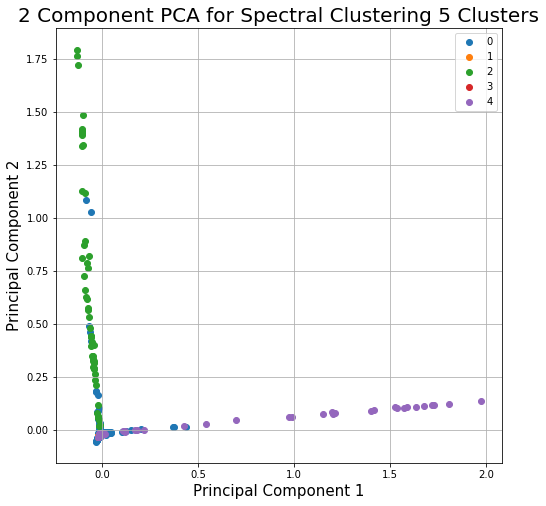

In [60]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA for Spectral Clustering 5 Clusters', fontsize = 20)
targets = [0,1,2,3,4]
colors = ['r', 'g', 'b','y','p']
for target, color in zip(targets,colors):
    indicesToKeep = principalDf['target'] == target
    ax.scatter(principalDf.loc[indicesToKeep, 'principal component 1']
               , principalDf.loc[indicesToKeep, 'principal component 2'])
ax.legend(targets)
ax.grid()

In [61]:
pickle.dump(sc_tedId_to_clusterId, open( "data/sctedId_to_clusterId100.pickle", "wb" ), protocol=2)

In [62]:
pickle.dump(sc_clusterId_to_tedId, open( "data/scclusterId_to_tedId2100.pickle", "wb" ), protocol=2)

## Random Forest Cluster Evaluation

### Dataset Initialization

In [26]:
cluster1DataX = None
cluster2DataX = None
cluster3DataX = None
cluster4DataX = None
cluster5DataX = None

cluster1Datay = None
cluster2Datay = None
cluster3Datay = None
cluster4Datay = None
cluster5Datay = None

### Dataset Cleaning

In [27]:
data = pd.read_csv('TedTalksNewFeatures.csv', encoding='latin1')

#drop things that we won't be able to oversample
data = data.drop('main_speaker', axis = 1)
data = data.drop('title', axis=1)
data = data.drop('Unnamed: 0', axis=1)
data = data.drop('ratings', axis=1)
data = data.drop('related_talks', axis=1)
data = data.drop('name', axis = 1)
data = data.drop('tags', axis = 1)
data = data.drop('description', axis = 1)
data = data.drop('event_class', axis = 1)
data = data.drop('event', axis = 1)

In [28]:
y = data['views']
X = data.drop('views', axis=1)

### Dataset Creation

In [29]:
for clusterNum, listIds in sc_clusterId_to_tedId.iteritems():
    XdataSplit = X.iloc[listIds]
    ydataSplit = y.iloc[listIds]
    if clusterNum == 0:
        cluster1X = XdataSplit
        cluster1y = ydataSplit
    if clusterNum == 1:
        cluster2X = XdataSplit
        cluster2y = ydataSplit
    if clusterNum == 2:
        cluster3X = XdataSplit
        cluster3y = ydataSplit
    if clusterNum == 3:
        cluster4X = XdataSplit
        cluster4y = ydataSplit
    if clusterNum == 4:
        cluster5X = XdataSplit
        cluster5y = ydataSplit

In [30]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(cluster1X, cluster1y, test_size=0.2, random_state=42)
X_train2, X_test2, y_train2, y_test2 = train_test_split(cluster2X, cluster2y, test_size=0.2, random_state=42)
X_train3, X_test3, y_train3, y_test3 = train_test_split(cluster3X, cluster3y, test_size=0.2, random_state=42)
X_train4, X_test4, y_train4, y_test4 = train_test_split(cluster4X, cluster4y, test_size=0.2, random_state=42)
X_train5, X_test5, y_train5, y_test5 = train_test_split(cluster5X, cluster5y, test_size=0.2, random_state=42)

In [31]:
X_train_sets = [X_train1,X_train2,X_train3,X_train4,X_train5]
y_train_sets = [y_train1,y_train2,y_train3,y_train4,y_train5]

X_test_sets = [X_test1,X_test2,X_test3,X_test4,X_test5]
y_test_sets = [y_test1,y_test2,y_test3,y_test4,y_test5]

### Grid Search for Optimal Hyperparameters for Random Forest

In [32]:
param_grid = [
  {
      'n_estimators': [50, 100, 200, 300], 
      'max_depth': [5, 10, 15, 20, 30, 40], 
      'max_features': ['sqrt']
  }
]

rfreg = RandomForestRegressor(n_jobs=-1,random_state=42) 
opt_parameters = [None] * CLUSTER_NUM
mse_results = []

for idx in range(CLUSTER_NUM):
    print(idx)
    CV_rfc = GridSearchCV(estimator = rfreg, param_grid = param_grid, cv = 5, verbose = 1)
    X_train = X_train_sets[idx]
    y_train = y_train_sets[idx]
    X_test = X_test_sets[idx]
    y_test = y_test_sets[idx]
    
    CV_rfc.fit(X_train, y_train)
    opt_parameters[idx] = CV_rfc.best_params_
    y_pred = CV_rfc.predict(X_test)
#     MSE_cluster = mean_squared_error(y_test, y_pred)
    MAE_cluster = mean_absolute_error(y_test, y_pred)
    mse_results.append(MAE_cluster)

In [36]:
sum(mse_results)/5

730157.1201110324

In [37]:
opt_parameters

[{'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 100},
 {'max_depth': 15, 'max_features': 10, 'n_estimators': 200},
 {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 100},
 {'max_depth': 10, 'max_features': 'log2', 'n_estimators': 100},
 {'max_depth': 5, 'max_features': 10, 'n_estimators': 300}]

In [38]:
mse_results

[820320.9810914515,
 518361.3025780075,
 474601.66049176373,
 891692.2197272729,
 945809.4366666666]